## Check the impact of changing c0

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 

PATH = '/scratch/users/robcking/era5_coarse_daily2015.nc'

ds = xr.open_dataset(PATH)


masks

In [2]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
ds_mask_trop = ds_mask_trop.rename(lat='latitude',lon='longitude')
interp_mask = ds_mask_trop.interp(latitude=ds.latitude,longitude=ds.longitude,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)

ds = ds.where(total_mask).stack(points=['latitude','longitude'])
ds = ds.dropna('points',how='all')
ds = ds.reset_index('points')
ds = ds.transpose('time','points','level')

In [3]:
u = ds.u.data
Ns = ds.Ns.data
rho = ds.rho.data
z = ds.z.data
lat =ds.latitude.data

loon

In [4]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = 'data/loon'
u_flux_ptv = []
u_flux_ntv = []
v_flux_ntv = []
v_flux_ptv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv.append(flux[2])    
    v_flux_ptv.append(flux[3])


loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_ntv_v = np.concatenate(v_flux_ntv)
loon_ptv_v = np.concatenate(v_flux_ptv)
loon_abs_v = np.concatenate([np.abs(loon_ntv_v)+np.abs(loon_ptv_v)])
loon_abs_u = np.concatenate([np.abs(loon_ntv_u)+np.abs(loon_ptv_u)])
loon_net_u = np.concatenate([loon_ntv_u+loon_ptv_u])
loon_net_v = np.concatenate([loon_ntv_v+loon_ptv_v])

LOON_DATA = {
    'u_flux_ntv': loon_ntv_u[loon_ntv_u<0],
    'u_flux_ptv': loon_ptv_u[loon_ptv_u>0],
    'v_flux_ntv': loon_ntv_v[loon_ntv_v<0],
    'v_flux_ptv': loon_ptv_v[loon_ptv_v>0],
    'u_flux_abs': loon_abs_u[loon_abs_u>0],
    'v_flux_abs': loon_abs_v[loon_abs_v>0],
    'u_flux_net': loon_net_u,
    'v_flux_net': loon_net_v
}

In [ ]:
from ad99py import AlexanderDunkerton1999

ad99_mima = AlexanderDunkerton1999(dc=0.4,use_intrinsic_c=10.0,exclude_unbroken=True)
ad99_always = AlexanderDunkerton1999(dc=0.4,use_intrinsic_c='always',exclude_unbroken=True)
ad99_never = AlexanderDunkerton1999(dc=0.4,use_intrinsic_c='never',exclude_unbroken=True)

In [6]:
from joblib import Parallel,delayed 
from tqdm.notebook import tqdm


def get_ad99(i:int,j:int,ad99:AlexanderDunkerton1999):
    ntv, ptv = ad99.momentum_flux_neg_ptv(u[i,j],Ns[i,j],z[i,j],rho[i,j],lat[j])
    return ntv,ptv


idxs = [(i, j) for i in range(u.shape[0]) for j in range(u.shape[1])]


results_mima = np.array(Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99_mima) for i,j in tqdm(idxs,total=u.shape[0]*u.shape[1],desc="Processing (i,j)")))
results_mima = results_mima.reshape((u.shape[0],u.shape[1],2,u.shape[2]))
results_mima_ntv = results_mima[...,0,:]
results_mima_ptv = results_mima[...,0,:]


results_always = np.array(Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99_always) for i,j in tqdm(idxs,total=u.shape[0]*u.shape[1],desc="Processing (i,j)")))
results_always = results_always.reshape((u.shape[0],u.shape[1],2,u.shape[2]))
results_always_ntv = results_always[...,0,:]
results_always_ptv = results_always[...,0,:]

results_never = np.array(Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99_never) for i,j in tqdm(idxs,total=u.shape[0]*u.shape[1],desc="Processing (i,j)")))
results_never = results_never.reshape((u.shape[0],u.shape[1],2,u.shape[2]))
results_never_ntv = results_never[...,0,:]
results_never_ptv = results_never[...,0,:]


Processing (i,j):   0%|          | 0/3323690 [00:00<?, ?it/s]

Processing (i,j):   0%|          | 0/3323690 [00:00<?, ?it/s]

Processing (i,j):   0%|          | 0/3323690 [00:00<?, ?it/s]

In [7]:
np.save('data/uw_c0_benchmark_10_ntv.npy',results_mima_ntv)
np.save('data/uw_c0_benchmark_10_ptv.npy',results_mima_ptv)

np.save('data/uw_c0_benchmark_always_ntv.npy',results_always_ntv)
np.save('data/uw_c0_benchmark_always_ptv.npy',results_always_ptv)

np.save('data/uw_c0_benchmark_never_ntv.npy',results_never_ntv)
np.save('data/uw_c0_benchmark_never_ptv.npy',results_never_ptv)

70hpa

In [39]:
level = 70#hpa 
i_level = np.argmin(np.abs(ds.level.values - level))

net_mima = results_mima_ptv + results_mima_ntv
net_always = results_always_ptv + results_always_ntv
net_never = results_never_ptv + results_never_ntv

In [40]:
net_mima_lvl = net_mima[...,i_level].ravel()*1000
net_mima_lvl = np.abs(net_mima_lvl)
net_mima_lvl = net_mima_lvl[net_mima_lvl > 0]

net_always_lvl = net_always[...,i_level].ravel()*1000
net_always_lvl = np.abs(net_always_lvl)
net_always_lvl = net_always_lvl[net_always_lvl > 0]

net_never_lvl = net_never[...,i_level].ravel()*1000
net_never_lvl = np.abs(net_never_lvl)
net_never_lvl = net_never_lvl[net_never_lvl > 0]


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_59417/3685514415.py:8: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(bincenter,mimahist,label='10 $\degree$ (MiMA)',)


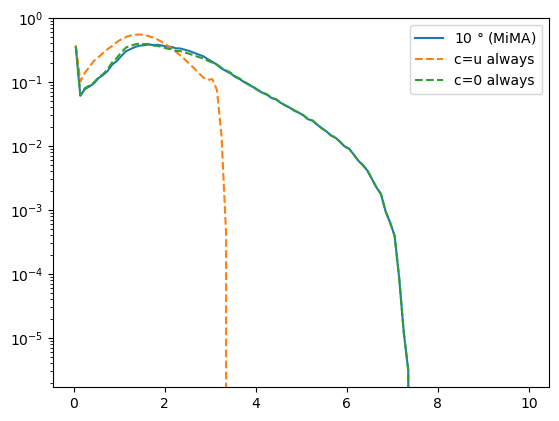

In [41]:
dc = 0.1
bins = np.arange(0,10+dc,dc)
bincenter = (bins[1:] + bins[:-1])*0.5
mimahist, _ = np.histogram(net_mima_lvl,density=True,bins=bins)
alwayshist,_ = np.histogram(net_always_lvl,density=True,bins=bins)
neverhist,_ = np.histogram(net_never_lvl,density=True,bins=bins)

plt.plot(bincenter,mimahist,label='10 $\degree$ (MiMA)',)
plt.plot(bincenter,alwayshist,label='c=u always',ls='--')
plt.plot(bincenter,neverhist,label='c=0 always',ls='--')
plt.yscale('log')
plt.legend()


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_59417/4064516216.py:8: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(bincenter,mimahist,label='10 $\degree$ (MiMA)',)


Text(0, 0.5, 'Probability Density')

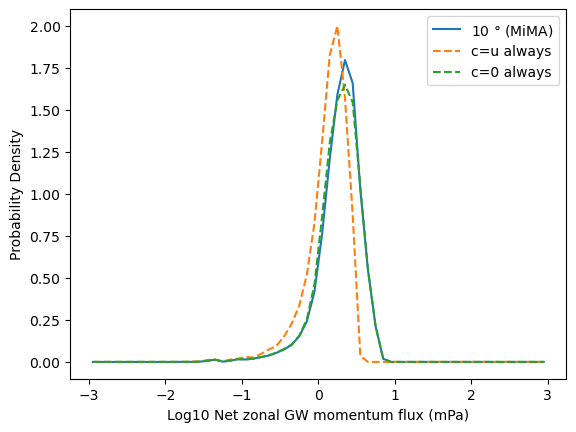

In [42]:
dc = 0.1
bins = np.arange(-3,3+dc,dc)
bincenter = (bins[1:] + bins[:-1])*0.5
mimahist, _ = np.histogram(np.log10(net_mima_lvl),density=True,bins=bins)
alwayshist,_ = np.histogram(np.log10(net_always_lvl),density=True,bins=bins)
neverhist,_ = np.histogram( np.log10(net_never_lvl),density=True,bins=bins)

plt.plot(bincenter,mimahist,label='10 $\degree$ (MiMA)',)
plt.plot(bincenter,alwayshist,label='c=u always',ls='--')
plt.plot(bincenter,neverhist,label='c=0 always',ls='--')
plt.legend()
plt.xlabel("Log10 Net zonal GW momentum flux (mPa)")
plt.ylabel("Probability Density")


In [15]:
mima

NameError: name 'mima' is not defined